# Nobel Twin Familial Cirrhosis Full MultiOmic Machine Learning Analysis
This notebook looks to combine the best performing features from serum metabolites (Selected Features, 49 Features), fecal metabolites (Songbird Top25+Bot25, 50 features) and fecal microbes (Selected Features, 27 features). To improve overall performance of model, I will be reducing the feature set using feature importance cutoffs, and adding metadata features (BMI, Age, Gender).

**Author: Tobin Groth (tgroth@ucsd.edu)**

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import qiime2
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from sklearn import metrics
from sklearn.utils import shuffle
import numpy as np
import pylab as pl
import qiime2
import os


os.chdir('/Users/tgroth/Google Drive/knight_twin_NAFLD/multiomic_analysis')

In [2]:
# loading in metadata
meta = pd.read_csv('../metadata-matched.tsv',sep='\t',index_col=0)
meta.head(3)

,ATTRIBUTE_AgeInYears,ATTRIBUTE_BarcodeSequence,ATTRIBUTE_BiologicalSex,ATTRIBUTE_ChromatographyAndPhase,ATTRIBUTE_ComorbidityListDOIDIndex,ATTRIBUTE_Country,ATTRIBUTE_DOIDCommonName,ATTRIBUTE_DOIDOntologyIndex,ATTRIBUTE_DepthorAltitudeMeters,ATTRIBUTE_Description,...,ATTRIBUTE_waist_circumference_cm,ATTRIBUTE_water_lot,ATTRIBUTE_wbc,ATTRIBUTE_weight,ATTRIBUTE_weight_units,ATTRIBUTE_well_description,ATTRIBUTE_well_id,ATTRIBUTE_zygocity,ATTRIBUTE_zygoticity,filename
sampleid,,,,,,,,,,,,,,,,,,,,,
TW-CO-002,54,TCATGGCCTCCG,male,not applicable,not applicable,United States of America,not applicable,not applicable,200,loomba_nobel_liver,...,98,RNBF9925,8,80.6,kg,Loomba_Twin_Plate_2_TW.CO.002_E2,E2,2,2.0,TW-CO-002_RC4_01_35874.mzXML
TW-BT-001,49,CACACAAAGTCA,female,not applicable,not applicable,United States of America,not applicable,not applicable,200,loomba_nobel_liver,...,92,RNBF9925,8.5,80.8,kg,Loomba_Twin_Plate_2_TW.BT.001_E10,E10,1,1.0,TW-BT-001_RH12_01_35942.mzXML
TW-CA-002,61,TCCGGCGGGCAA,male,not applicable,not applicable,United States of America,not applicable,not applicable,200,loomba_nobel_liver,...,115,RNBF9925,6.2,99.7,kg,Loomba_Twin_Plate_2_TW.CA.002_B10,B10,1,1.0,TW-CA-002_RH6_01_35936.mzXML


In [4]:
# loading in the multiomic scaled feature table
multi_tablepd = pd.read_csv('./feature_tables/full-multiomic-ft-scaled.tsv',sep='\t',index_col=0)
multi_tablepd.head(3)

,cdf8d23687cfc324485e2bd3e0094ff2,fb758530086adf438d5ebe8f83847f2d,d2ef3361261cc1d835ad59394bfe161c,0ba75f593218ef056eefaeab285ae839,3d7f155024af16ecbe4c9baefdd571be,c0095c69fee5c767903814b366fcb860,54e3ef405d9d82cfed4858f3191c2522,6ba039413a4b798ba234b05c568ff300,53cb1796cbb423bcd59853acdf63befe,f7dd0dbd9e8f975d44295498a1c3aa85,...,TACGTAGGTGGCAAGCGTTGTCCGGAATTATTGGGCGTAAAGCGCGCGCAGGCGGATAGGTCAGTCTGTCTTAAAAGTTCGGGGCTTAACCCCGTGATGGGATGGAAACTGCCAATCTAGAGTATCGGAGAGGAAAGTGGAATTCCTAGT,TACGTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAGCGTAGACGGTTAAGCAAGTCTGAAGTGAAAGCCCGGGGCTCAACCCCGGTACTGCTTTGGAAACTGTTTGACTTGAGTGCAGGAGAGGTAAGTGGAATTCCTAG,TACGTAGGTGGCAAGCGTTGTCCGGATTTACTGGGTGTAAAGGGCGTGCAGCCGGGCCGGCAAGTCAGATGTGAAATCTGGAGGCTTAACCTCCAAACTGCATTTGAAACTGTAGGTCTTGAGTACCGGAGAGGTTATCGGAATTCCTTG,TACGTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAGCGTAGACGGAAGAGCAAGTCTGATGTGAAAGGCTGGGGCTTAACCCCAGGACTGCATTGGAAACTGTTTTTCTAGAGTGCCGGAGAGGTAAGCGGAATTCCTAG,TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAGCGTAGGTGGATTGTTAAGTCAGTTGTGAAAGTTTGCGGCTCAACCGTAAAATTGCAGTTGAAACTGGCAGTCTTGAGTACAGTAGAGGTGGGCGGAATTCGTGG,TACGTAGGTGGCAAGCGTTATCCGGAATCATTGGGCGTAAAGGGTGCGTAGGTGGCGTACTAAGTCTGTAGTAAAAGGCAATGGCTCAACCATTGTAAGCTATGGAAACTGGTATGCTGGAGTGCAGAAGAGGGCGATGGAATTCCATGT,TACGTAGGTGGCGAGCGTTATCCGGAATTATTGGGCGTAAAGAGGGAGCAGGCGGCGGCAGAGGTCTGTGGTGAAAGACTGAAGCTTAACTTCAGTAAGCCATAGAAACCGGGCTGCTAGAGTGCAGGAGAGGATCGTGGAATTCCATGT,AACGTAGGTCACAAGCGTTGTCCGGAATTACTGGGTGTAAAGGGAGCGCAGGCGGGAAGACAAGTTGGAAGTGAAATCCATGGGCTCAACCCATGAACTGCTTTCAAAACTGTTTTTCTTGAGTAGTGCAGAGGTAGGCGGAATTCCCGG,TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAGCGTAGATGGATGTTTAAGTCAGTTGTGAAAGTTTGCGGCTCAACCGTAAAATTGCAGTTGATACTGGATGTCTTGAGTGCAGTTGAGGCAGGCGGAATTCGTGG,TACGTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAGCGTAGACGGCGAAGCAAGTCTGAAGTGAAAACCCAGGGCTCAACCCTGGGACTGCTTTGGAAACTGTTTTGCTAGAGTGTCGGAGAGGTAAGTGGAATTCCTAG
TW-CO-002,-0.097968,-0.129545,-0.109753,-0.113338,-0.197325,-0.202576,-0.235192,-0.261255,-0.260321,-0.243276,...,-0.090252,-0.139397,-0.481841,-0.166574,-0.409194,-0.284873,0.638761,-0.418581,-0.244820,-0.281017
TW-BT-001,-0.097968,-0.129545,-0.109753,-0.113338,-0.197325,-0.202576,-0.235192,-0.261255,-0.260321,-0.243276,...,-0.090252,-0.139397,-0.481841,-0.166574,-0.462937,-0.284873,-0.453259,-0.464552,-0.238921,-0.281017
TW-CA-002,-0.097968,-0.129545,-0.109753,-0.113338,-0.197325,-0.202576,-0.235192,-0.261255,-0.260321,-0.243276,...,-0.090252,-0.139397,-0.481841,-0.166574,-0.471895,-0.284873,0.006539,-0.450761,-0.244820,-0.281017


# 1. Building Baseline Models

## 1a. Cross Validating and Training on G1P+G3P 

In [5]:
# get all the samples that are G1P and G3P
samples_train = ([idx for idx in meta[meta.ATTRIBUTE_groups=='G1P'].index]
            + [idx for idx in meta[meta.ATTRIBUTE_groups=='G3P'].index])
exp_train = meta.loc[samples_train][['ATTRIBUTE_groups','ATTRIBUTE_adv_fibrosis']]
exp_train.rename(columns={'ATTRIBUTE_groups':'groups','ATTRIBUTE_adv_fibrosis':'adv_fibrosis'},inplace=True)
print(exp_train.groups.value_counts())
print(exp_train.adv_fibrosis.value_counts())

G1P    48
G3P    22
Name: groups, dtype: int64
0                         44
1                         22
Missing: Not collected     4
Name: adv_fibrosis, dtype: int64


**Can see the 4 Missing: Not collected individuals are from G1P and therefore are 0 for AF**


In [7]:
# preparing training data for base model
x_train_base = multi_tablepd.loc[exp_train.index]
# label encoder
y_train_base = []
for idx in exp_train.index:
    if exp_train.loc[idx,'adv_fibrosis'] == '1':
        y_train_base.append(1)
    # values that are 'missing' are still 0 for adv fibrosis
    else:
        y_train_base.append(0)
y_train_base = np.array(y_train_base)
print(len(x_train_base.index))
print(len(y_train_base))

70
70


In [8]:
# creating method for cross validating model by plotting ROC
# cf==0 for log reg, cf==1 for RF
def cross_val_roc(cf, x_train, y_train, title, split=5,):
    from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
    from sklearn.linear_model import LogisticRegression
    from sklearn.metrics import roc_curve, auc

    
    fig = plt.figure()
    ax = plt.subplot(111)
    
    # Run classifier with cross validation and plot ROC curves
    cv =StratifiedShuffleSplit(n_splits=split, test_size=0.3, random_state=9)
    if cf == 0:
        cf_test1 = LogisticRegression(random_state=0,max_iter=500)
    else:
        cf_test1 = RandomForestClassifier(n_estimators=500, n_jobs=4, random_state=0)

    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    all_tpr = []
    for train, test in cv.split(x_train,y_train):
        probas_ = cf_test1.fit(x_train.iloc[train], y_train[train]).predict_proba(x_train.iloc[test])
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y_train[test], probas_[:,1])
        mean_tpr += np.interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        roc_auc = auc(fpr, tpr)
        pl.plot(fpr, tpr, lw=1, label='ROC (area = %0.2f)' %  roc_auc)

    pl.plot([0, 1], [0, 1], '--', color=(0.6,0.6,0.6), label='Luck')
    mean_tpr /= cv.get_n_splits()
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    pl.plot(mean_fpr, mean_tpr, 'k--',
            label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)

    pl.xlim([-0.05,1.05])
    pl.ylim([-0.05,1.05])
    pl.xlabel('False Positive Rate')
    pl.ylabel('True Positive Rate')
    pl.title(title)
    ax.legend(bbox_to_anchor=(1, 1))
    return pl

In [9]:
# creating method for cross validating model by plotting Precision-Recall curve
# cf==0 for log reg, cf==1 for RF
def cross_val_pr(cf, x_train, y_train, title, split=5,):
    from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
    from sklearn.metrics import precision_recall_curve
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.linear_model import LogisticRegression
    from sklearn.metrics import roc_curve, auc
    from scipy import interp

    
    fig = plt.figure()
    ax = plt.subplot(111)
    
    # Run classifier with crossvalidation and plot precision-recall curves
    cv =StratifiedShuffleSplit(n_splits=split, test_size=0.4, random_state=9)
    if cf == 0:
        cf_test1 = LogisticRegression(random_state=0,max_iter=500)
    else:
        cf_test1 = RandomForestClassifier(n_estimators=500, n_jobs=4, random_state=0)

    mean_precision = 0.0
    mean_recall = np.linspace(1, 0, 100)
    all_precision = []

    for train, test in cv.split(x_train,y_train):
        probas_ = cf_test1.fit(x_train.iloc[train], y_train[train]).predict_proba(x_train.iloc[test])
        # Compute precision-recall curve and area the curve
        precision, recall, thresholds = precision_recall_curve(y_train[test], probas_[:,1])
        rev_recall = recall[::-1]
        rev_precision = precision[::-1]
        mp = np.interp(mean_recall, rev_recall, rev_precision)
        mean_precision += mp
        pr_auc = auc(rev_recall, rev_precision)
        plt.plot(recall, precision, lw=1, label='Precision-Recall (area = %0.2f)' %  pr_auc)

    mean_precision /= cv.get_n_splits()
    mean_auc = auc(mean_recall, mean_precision)
    plt.plot(mean_recall, mean_precision, 'k--',
            label='Mean Precision-Recall (area = %0.2f)' % mean_auc, lw=2)

    plt.xlim([-0.05,1.05])
    plt.ylim([-0.05,1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(title)
    ax.legend(bbox_to_anchor=(1, 1))
    return plt

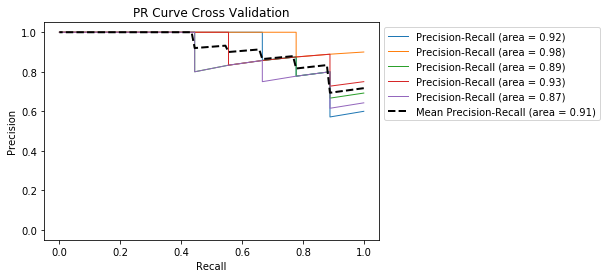

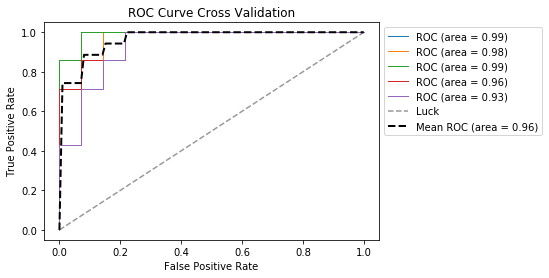

In [10]:
# plotting CV for Log Reg
lr_fig = cross_val_pr(0,x_train_base,y_train_base,'PR Curve Cross Validation')
lr_fig.savefig('./ml_analysis/full_multiomic_figures/lr_base_cv_pr.pdf',bbox_inches='tight')

lr_fig = cross_val_roc(0,x_train_base,y_train_base,'ROC Curve Cross Validation')
lr_fig.savefig('./ml_analysis/full_multiomic_figures/lr_base_cv_roc.pdf',bbox_inches='tight')

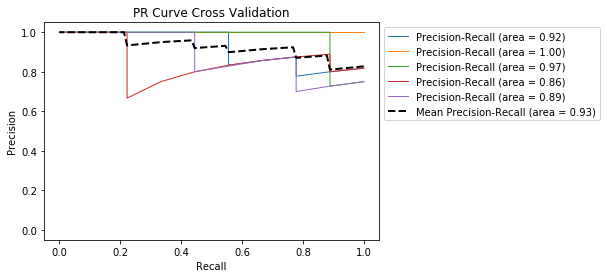

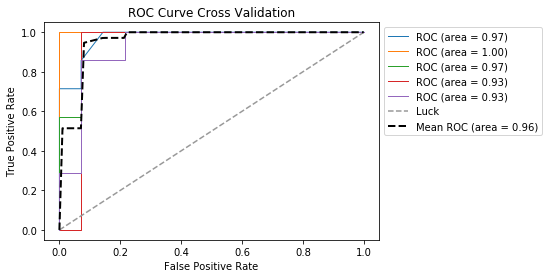

In [11]:
# plot CV for Random Forest
rf_fig = cross_val_pr(1,x_train_base,y_train_base,'PR Curve Cross Validation')
rf_fig.savefig('./ml_analysis/full_multiomic_figures/rf_base_cv_pr.pdf',bbox_inches='tight')

rf_fig = cross_val_roc(1,x_train_base,y_train_base,'ROC Curve Cross Validation')
rf_fig.savefig('./ml_analysis/full_multiomic_figures/rf_base_cv_roc.pdf',bbox_inches='tight')

In [12]:
# training Log Reg on training data
base_lr = LogisticRegression(random_state=0,max_iter=200)
base_lr.fit(x_train_base, y_train_base)

LogisticRegression(max_iter=200, random_state=0)

In [13]:
# training RF on training data
base_rf = RandomForestClassifier(500, oob_score=True, random_state=0)
base_rf.fit(x_train_base, y_train_base)
base_rf.oob_score_

0.8857142857142857

## 1b. Testing models on G3R

In [14]:
# get all the samples that are G3R
samples_test = [idx for idx in meta[meta.ATTRIBUTE_groups=='G3R'].index if idx in multi_tablepd.index]
exp_test = meta.loc[samples_test][['ATTRIBUTE_groups','ATTRIBUTE_adv_fibrosis']]
exp_test.rename(columns={'ATTRIBUTE_groups':'groups','ATTRIBUTE_adv_fibrosis':'adv_fibrosis'},inplace=True)
# have to drop Missing: Not collected values
exp_test = exp_test[exp_test.adv_fibrosis != 'Missing: Not collected']
print(exp_test.adv_fibrosis.value_counts())

0    21
1     7
Name: adv_fibrosis, dtype: int64


In [15]:
# Preparing the test base data
x_test_base = multi_tablepd.loc[exp_test.index]
y_test_base = []
for idx in exp_test.index:
    if exp_test.loc[idx,'adv_fibrosis'] == '1':
        y_test_base.append(1)
    elif exp_test.loc[idx,'adv_fibrosis'] == '0':
        y_test_base.append(0)
y_test_base = np.array(y_test_base)
print(len(x_test_base))
print(len(y_test_base))

28
28


In [16]:
# plotting Precision Recall curve 
# (code used from calour.plot_roc http://biocore.github.io/calour/generated/calour.training.plot_roc.html)
def plot_result_pr(result,title,cv=True):
    from sklearn import metrics
    from matplotlib import pyplot as plt
    import itertools
    
    cmap = plt.cm.Dark2
    fig, ax = plt.subplots()
    ax.set_aspect('equal')

    classes = np.unique(result['Y_TRUE'].values)
    classes.sort()

    col = dict(zip(classes, itertools.cycle(cmap.colors)))

    mean_recall = np.linspace(1, 0, 100)
    for cls in classes:
        precisions = []
        aucs = []
        if cv is True:
            for grp, df in result.groupby('CV'):
                y_true = df['Y_TRUE'].values == cls
                precision, recall, thresholds = metrics.precision_recall_curve(y_true.astype(int), result[cls])
                rev_recall = recall[::-1]
                rev_precision = precision[::-1]
                mean_precision = np.interp(mean_recall, rev_recall, rev_precision)
                precisions.append(mean_precision)
                precisions[-1][0] = 0.0
                pr_auc = metrics.auc(mean_recall, mean_precision)
                aucs.append(pr_auc)

            mean_precision = np.mean(precisions, axis=0)
            #mean_tpr[-1] = 1.0
            mean_auc = np.mean(aucs)
            std_auc = np.std(aucs)
            ax.plot(mean_recall, mean_precision, color=col[cls],
                    label='{0} ({1:.2f} $\\pm$ {2:.2f})'.format(cls, mean_auc, std_auc),
                    lw=2, alpha=.8)

            std_precision = np.std(precisions, axis=0)
            precisions_upper = np.minimum(mean_precision + std_precision, 1)
            precisions_lower = np.maximum(mean_precision - std_precision, 0)
            ax.fill_between(mean_recall, precisions_lower, precisions_upper, color=col[cls], alpha=.5)
        else:
            y_true = result['Y_TRUE'].values == cls
            precision, recall, thresholds = metrics.precision_recall_curve(y_true.astype(int), result[cls])
            pr_auc = auc(recall, precision)
            # prepend zero because, if not, the curve may start in the middle of the plot.
            ax.plot(np.insert(recall, 0, 0), np.insert(precision, 0, 0), label='{0} ({1:.2f})'.format(cls, pr_auc), lw=2)

    ax.set_xlim(-0.05, 1.05)
    ax.set_ylim(-0.05, 1.05)
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_title(title)
    ax.legend(loc="lower right")

    return plt

In [17]:
# plotting ROC curve 
# (code used from calour.plot_roc http://biocore.github.io/calour/generated/calour.training.plot_roc.html)
def plot_result_roc(result,title,cv=True):    
    from sklearn import metrics
    from matplotlib import pyplot as plt
    import itertools
    
    cmap = plt.cm.Dark2
    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    ax.plot([0, 1], [0, 1], linestyle='-', lw=1, color='black', label='Luck', alpha=.5)

    classes = np.unique(result['Y_TRUE'].values)
    classes.sort()

    col = dict(zip(classes, itertools.cycle(cmap.colors)))

    mean_fpr = np.linspace(0, 1, 100)
    for cls in classes:
        tprs = []
        aucs = []
        if cv is True:
            for grp, df in result.groupby('CV'):
                y_true = df['Y_TRUE'].values == cls
                fpr, tpr, thresholds = metrics.roc_curve(y_true.astype(int), df[cls])
                mean_tpr = np.interp(mean_fpr, fpr, tpr)
                tprs.append(mean_tpr)
                tprs[-1][0] = 0.0
                roc_auc = metrics.auc(mean_fpr, mean_tpr)
                aucs.append(roc_auc)

            mean_tpr = np.mean(tprs, axis=0)
            mean_tpr[-1] = 1.0
            mean_auc = np.mean(aucs)
            std_auc = np.std(aucs)
            ax.plot(mean_fpr, mean_tpr, color=col[cls],
                    label='{0} ({1:.2f} $\\pm$ {2:.2f})'.format(cls, mean_auc, std_auc),
                    lw=2, alpha=.8)

            std_tpr = np.std(tprs, axis=0)
            tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
            tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
            ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color=col[cls], alpha=.5)
        else:
            y_true = result['Y_TRUE'].values == cls
            fpr, tpr, thresholds = roc_curve(y_true.astype(int), result[cls])
            roc_auc = auc(fpr, tpr)
            # prepend zero because, if not, the curve may start in the middle of the plot.
            ax.plot(np.insert(fpr, 0, 0), np.insert(tpr, 0, 0), label='{0} ({1:.2f})'.format(cls, roc_auc), lw=2)

    ax.set_xlim(-0.05, 1.05)
    ax.set_ylim(-0.05, 1.05)
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(title)
    ax.legend(loc="lower right")

    return plt

In [18]:
# testing the logistic regression base model
result_base_lr = pd.DataFrame(base_lr.predict_proba(x_test_base))
result_base_lr.columns = base_lr.classes_
result_base_lr['Y_TRUE'] = y_test_base
result_base_lr['CV'] = 0

Average precision-recall score: 0.29


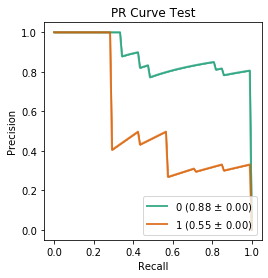

In [19]:
fig_base_lr = plot_result_pr(result_base_lr,'PR Curve Test')
fig_base_lr.savefig('./ml_analysis/full_multiomic_figures/lr_base_test_pr.pdf',bbox_inches='tight')

average_precision = metrics.average_precision_score(y_test_base, base_lr.predict(x_test_base))

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

Accuracy score: 0.54


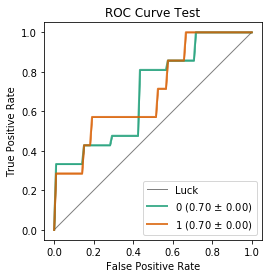

In [20]:
fig_base_lr = plot_result_roc(result_base_lr,'ROC Curve Test')
fig_base_lr.savefig('./ml_analysis/full_multiomic_figures/lr_base_test_roc.pdf',bbox_inches='tight')

acc_score = metrics.accuracy_score(y_test_base, base_lr.predict(x_test_base))

print('Accuracy score: {0:0.2f}'.format(
      acc_score))

In [21]:
# testing the random forest base model
result_base_rf = pd.DataFrame(base_rf.predict_proba(x_test_base))
result_base_rf.columns = base_rf.classes_
result_base_rf['Y_TRUE'] = y_test_base
result_base_rf['CV'] = 0

Average precision-recall score: 0.25


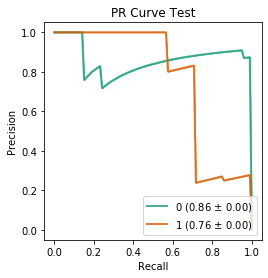

In [22]:
fig_base_rf = plot_result_pr(result_base_rf,'PR Curve Test')
fig_base_rf.savefig('./ml_analysis/full_multiomic_figures/rf_base_test_pr.pdf',bbox_inches='tight')

average_precision = metrics.average_precision_score(y_test_base, base_rf.predict(x_test_base))

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

Accuracy score: 0.32


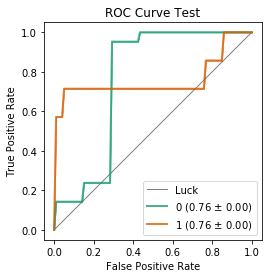

In [23]:
fig_base_rf = plot_result_roc(result_base_rf,'ROC Curve Test')
fig_base_rf.savefig('./ml_analysis/full_multiomic_figures/rf_base_test_roc.pdf',bbox_inches='tight')

acc_score = metrics.accuracy_score(y_test_base, base_rf.predict(x_test_base))

print('Accuracy score: {0:0.2f}'.format(
      acc_score))

**Next we will use feature importance to select features to see if that can improve our model**

In [24]:
# extracting the important features from our classifier
base_fimp1 = pd.Series(base_rf.feature_importances_).sort_values(ascending=False)
base_fimp1 = base_fimp1.to_frame()
base_fimp1.columns = ['imp_score']
base_fimp1.head(5)

,imp_score
64,0.059913
60,0.053792
86,0.047627
66,0.047586
84,0.041478


In [43]:
# extracting the features that have a feature importance over the threshold of 0.01
top_feat1 = list(base_fimp1[base_fimp1['imp_score']>0.003].index)
print('There are %d features with importance >0.003' %len(top_feat1))

There are 58 features with importance >0.003


In [44]:
# Calculating which features were included
fecal = pd.read_csv('./feature_tables/fecal-ft-mlfeat.tsv',sep='\t',index_col=0).columns
serum = pd.read_csv('./feature_tables/serum-ft-mlfeat.tsv',sep='\t',index_col=0).columns
microbiome = pd.read_csv('./feature_tables/microbiome-ft-mlfeat.tsv',sep='\t',index_col=0).columns
feat_list = multi_tablepd.columns[top_feat1]
feat_loc = []
for feat in feat_list:
    if feat in fecal:
        feat_loc.append('fecal')
    elif feat in serum:
        feat_loc.append('serum')
    elif feat in microbiome:
        feat_loc.append('microbiome')
print(str(feat_loc.count('fecal'))+' Total Fecal Metabolites')
print(str(feat_loc.count('serum'))+' Total Serum Metabolites')
print(str(feat_loc.count('microbiome'))+' Total Fecal Microbes')

3 Total Fecal Metabolites
43 Total Serum Metabolites
12 Total Fecal Microbes


## 2. Building New Models Using Selected Features

### 2a. CV/Train model on G1P+G3P

In [45]:
# getting samples to train on
exp_train.groups.value_counts()

G1P    48
G3P    22
Name: groups, dtype: int64

In [46]:
# preparing training data
x_train_feat1 = multi_tablepd.loc[exp_train.index]
x_train_feat1 = x_train_feat1.iloc[:,top_feat1]
#l abel encoder
y_train_feat1 = []
for idx in exp_train.index:
    if exp_train.loc[idx,'adv_fibrosis'] == '1':
        y_train_feat1.append(1)
    # even values that are 'missing' are still 0 for adv fibrosis
    else:
        y_train_feat1.append(0)
y_train_feat1 = np.array(y_train_feat1)
# ensuring we have correct samples x features
print(x_train_feat1.shape)
print(len(y_train_feat1))

(70, 58)
70


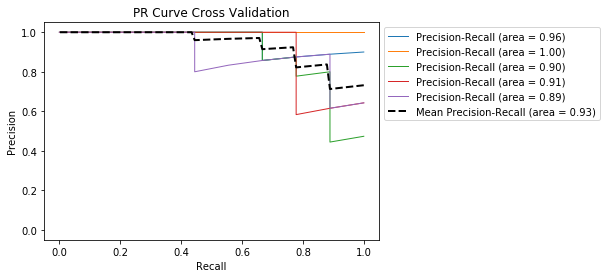

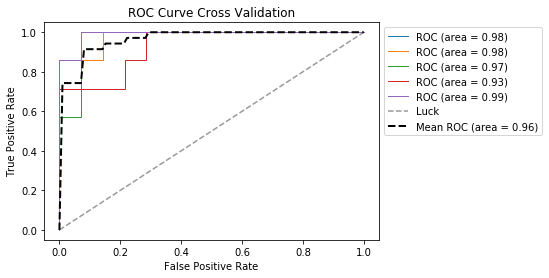

In [47]:
# plotting CV for LogReg
fig_lr = cross_val_pr(0,x_train_feat1,y_train_feat1,'PR Curve Cross Validation')
fig_lr.savefig('ml_analysis/full_multiomic_figures/lr_selected_cv_pr.pdf',bbox_inches='tight')

fig_lr = cross_val_roc(0,x_train_feat1,y_train_feat1,'ROC Curve Cross Validation')
fig_lr.savefig('ml_analysis/full_multiomic_figures/lr_selected_cv_roc.pdf',bbox_inches='tight')

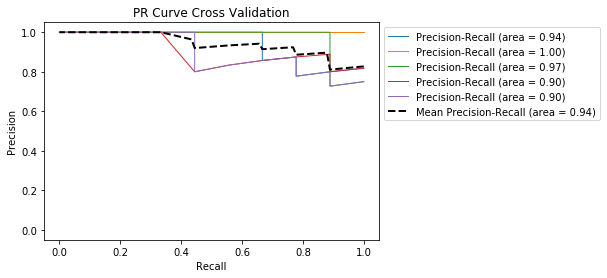

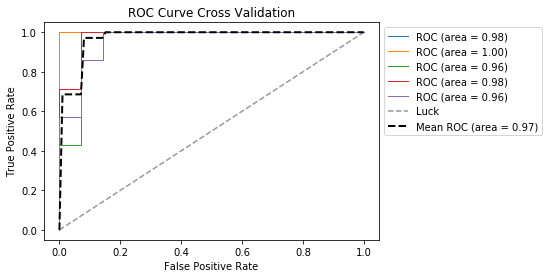

In [48]:
# plotting CV for RF
fig_rf = cross_val_pr(1,x_train_feat1,y_train_feat1,'PR Curve Cross Validation')
fig_rf.savefig('ml_analysis/full_multiomic_figures/rf_selected_cv_pr.pdf',bbox_inches='tight')

fig_rf = cross_val_roc(1,x_train_feat1,y_train_feat1,'ROC Curve Cross Validation')
fig_rf.savefig('ml_analysis/full_multiomic_figures/rf_selected_cv_roc.pdf',bbox_inches='tight')


In [49]:
# training Log Reg on training data
feat1_lr = LogisticRegression(random_state=0,max_iter=200)
feat1_lr.fit(x_train_feat1, y_train_feat1)

LogisticRegression(max_iter=200, random_state=0)

In [50]:
# training RF on training data
feat1_rf = RandomForestClassifier(500, oob_score=True, random_state=0)
feat1_rf.fit(x_train_feat1, y_train_feat1)
feat1_rf.oob_score_

0.9

### 2b. Testing Models on G3R Samples

In [51]:
exp_test.adv_fibrosis.value_counts()

0    21
1     7
Name: adv_fibrosis, dtype: int64

In [52]:
# Preparing the test data
x_test_feat1 = multi_tablepd.loc[exp_test.index]
x_test_feat1 = x_test_feat1.iloc[:,top_feat1]
y_test_feat1 = []
for idx in exp_test.index:
    if exp_test.loc[idx,'adv_fibrosis'] == '1':
        y_test_feat1.append(1)
    elif exp_test.loc[idx,'adv_fibrosis'] == '0':
        y_test_feat1.append(0)
y_test_feat1 = np.array(y_test_feat1)
print(x_test_feat1.shape)
print(len(y_test_feat1))

(28, 58)
28


In [53]:
# testing log reg
result_feat1_lr = pd.DataFrame(feat1_lr.predict_proba(x_test_feat1))
result_feat1_lr.columns = feat1_lr.classes_
result_feat1_lr['Y_TRUE'] = y_test_feat1
result_feat1_lr['CV'] = 0

Average precision-recall score: 0.26


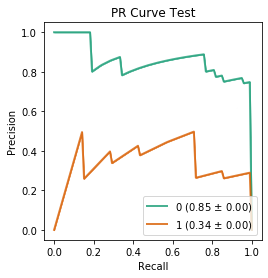

In [54]:
fig_feat1_lr = plot_result_pr(result_feat1_lr,'PR Curve Test')
fig_feat1_lr.savefig('ml_analysis/full_multiomic_figures/lr_selected_test_pr.pdf',bbox_inches='tight')

average_precision = metrics.average_precision_score(y_test_feat1, feat1_lr.predict(x_test_feat1))

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

Accuracy score: 0.43


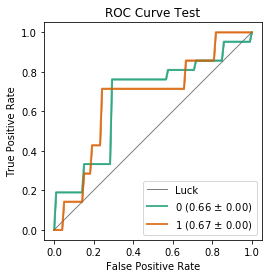

In [55]:
fig_feat1_lr = plot_result_roc(result_feat1_lr,'ROC Curve Test')
fig_feat1_lr.savefig('ml_analysis/full_multiomic_figures/lr_selected_test_roc.pdf',bbox_inches='tight')

acc_score = metrics.accuracy_score(y_test_feat1, feat1_lr.predict(x_test_feat1))

print('Accuracy score: {0:0.2f}'.format(
      acc_score))

In [56]:
# testing the random forest selected feature model
result_feat1_rf = pd.DataFrame(feat1_rf.predict_proba(x_test_feat1))
result_feat1_rf.columns = feat1_rf.classes_
result_feat1_rf['Y_TRUE'] = y_test_feat1
result_feat1_rf['CV'] = 0

Average precision-recall score: 0.25


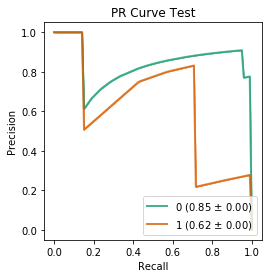

In [57]:
fig_feat1_rf = plot_result_pr(result_feat1_rf,'PR Curve Test')
fig_feat1_rf.savefig('ml_analysis/full_multiomic_figures/rf_selected_test_pr.pdf',bbox_inches='tight')

average_precision = metrics.average_precision_score(y_test_feat1, feat1_rf.predict(x_test_feat1))

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

Accuracy score: 0.32


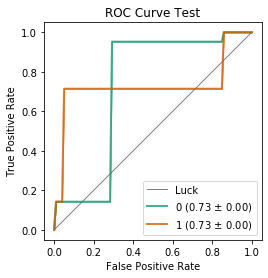

In [58]:
fig_feat1_rf = plot_result_roc(result_feat1_rf,'ROC Curve Test')
fig_feat1_rf.savefig('ml_analysis/full_multiomic_figures/rf_selected_test_roc.pdf',bbox_inches='tight')

acc_score = metrics.accuracy_score(y_test_feat1, feat1_rf.predict(x_test_feat1))

print('Accuracy score: {0:0.2f}'.format(
      acc_score))

# 3. Adding BMI, Gender and Age to Base Feature Set
Previous analyses have shown that adding in the metadata features above, can strongly improve the performance of the models. I will first add the metadata features to the base multi-omic model.

In [61]:
# pulling clinical features from metadata
clin_feat = meta.loc[:,['ATTRIBUTE_BiologicalSex','ATTRIBUTE_bmi','ATTRIBUTE_age']]
clin_feat.rename(columns={"ATTRIBUTE_BiologicalSex": "gender", "ATTRIBUTE_bmi": "bmi","ATTRIBUTE_age":"age"},inplace=True)
clin_feat

,gender,bmi,age
sampleid,,,
TW-CO-002,male,27.900000,54
TW-BT-001,female,25.400000,49
TW-CA-002,male,36.400000,61
TW-BD-002,female,36.800000,32
TW-AV-001,female,29.100000,61
...,...,...,...
CIR55-002,female,37.663593,73
CIR26-002,male,34.562874,81
CIR5-002,female,56.759058,39


In [62]:
# combine base data with clinical features
x_train_comb = pd.concat([x_train_base, clin_feat.loc[exp_train.index]],axis=1)
x_train_comb.gender = pd.factorize(x_train_comb.gender)[0]
print(x_train_comb.shape)
x_train_comb.head(3)

(70, 129)


,cdf8d23687cfc324485e2bd3e0094ff2,fb758530086adf438d5ebe8f83847f2d,d2ef3361261cc1d835ad59394bfe161c,0ba75f593218ef056eefaeab285ae839,3d7f155024af16ecbe4c9baefdd571be,c0095c69fee5c767903814b366fcb860,54e3ef405d9d82cfed4858f3191c2522,6ba039413a4b798ba234b05c568ff300,53cb1796cbb423bcd59853acdf63befe,f7dd0dbd9e8f975d44295498a1c3aa85,...,TACGTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAGCGTAGACGGAAGAGCAAGTCTGATGTGAAAGGCTGGGGCTTAACCCCAGGACTGCATTGGAAACTGTTTTTCTAGAGTGCCGGAGAGGTAAGCGGAATTCCTAG,TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAGCGTAGGTGGATTGTTAAGTCAGTTGTGAAAGTTTGCGGCTCAACCGTAAAATTGCAGTTGAAACTGGCAGTCTTGAGTACAGTAGAGGTGGGCGGAATTCGTGG,TACGTAGGTGGCAAGCGTTATCCGGAATCATTGGGCGTAAAGGGTGCGTAGGTGGCGTACTAAGTCTGTAGTAAAAGGCAATGGCTCAACCATTGTAAGCTATGGAAACTGGTATGCTGGAGTGCAGAAGAGGGCGATGGAATTCCATGT,TACGTAGGTGGCGAGCGTTATCCGGAATTATTGGGCGTAAAGAGGGAGCAGGCGGCGGCAGAGGTCTGTGGTGAAAGACTGAAGCTTAACTTCAGTAAGCCATAGAAACCGGGCTGCTAGAGTGCAGGAGAGGATCGTGGAATTCCATGT,AACGTAGGTCACAAGCGTTGTCCGGAATTACTGGGTGTAAAGGGAGCGCAGGCGGGAAGACAAGTTGGAAGTGAAATCCATGGGCTCAACCCATGAACTGCTTTCAAAACTGTTTTTCTTGAGTAGTGCAGAGGTAGGCGGAATTCCCGG,TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAGCGTAGATGGATGTTTAAGTCAGTTGTGAAAGTTTGCGGCTCAACCGTAAAATTGCAGTTGATACTGGATGTCTTGAGTGCAGTTGAGGCAGGCGGAATTCGTGG,TACGTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAGCGTAGACGGCGAAGCAAGTCTGAAGTGAAAACCCAGGGCTCAACCCTGGGACTGCTTTGGAAACTGTTTTGCTAGAGTGTCGGAGAGGTAAGTGGAATTCCTAG,gender,bmi,age
sampleid,,,,,,,,,,,,,,,,,,,,,
TW-BS-002,-0.097968,-0.129545,-0.109753,-0.113338,-0.197325,-0.202576,-0.235192,-0.261255,-0.260321,-0.243276,...,-0.166574,1.319567,-0.044601,0.006539,-0.082995,6.252286,-0.070664,0,28.8,22
TW-BU-002,-0.097968,-0.129545,-0.109753,-0.113338,-0.197325,-0.202576,-0.235192,-0.261255,-0.260321,-0.243276,...,0.171214,-0.471895,-0.284873,2.363003,-0.464552,-0.244820,-0.175840,1,23.7,22
TW-BK-001,0.240258,0.544569,0.337667,0.387358,1.243826,1.401201,-0.235192,-0.261255,2.141761,-0.243276,...,-0.166574,-0.140474,-0.284873,0.121488,-0.060010,-0.244820,-0.281017,1,26.6,60


In [63]:
# prepare training data
y_train_comb = []
for idx in x_train_comb.index:
    if meta.loc[idx, 'ATTRIBUTE_adv_fibrosis'] == '1':
        y_train_comb.append(1)
    else:    
        y_train_comb.append(0)
y_train_comb = np.array(y_train_comb)
print(len(y_train_comb))

70


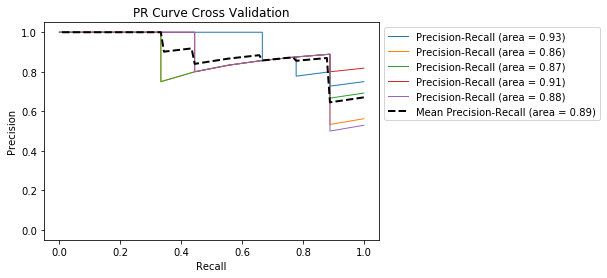

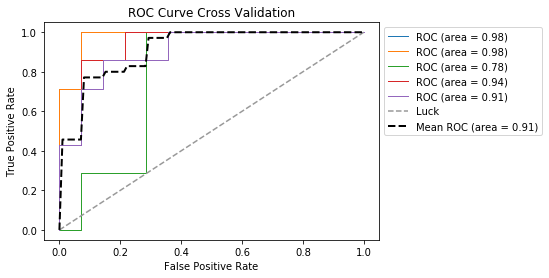

In [64]:
# plot CV for LogReg
fig_lr = cross_val_pr(0,x_train_comb,y_train_comb,'PR Curve Cross Validation')
fig_lr.savefig('ml_analysis/full_multiomic_figures/lr_base+meta_cv_pr.pdf',bbox_inches='tight')

fig_lr = cross_val_roc(0,x_train_comb,y_train_comb,'ROC Curve Cross Validation')
fig_lr.savefig('ml_analysis/full_multiomic_figures/lr_base+meta_cv_roc.pdf',bbox_inches='tight')


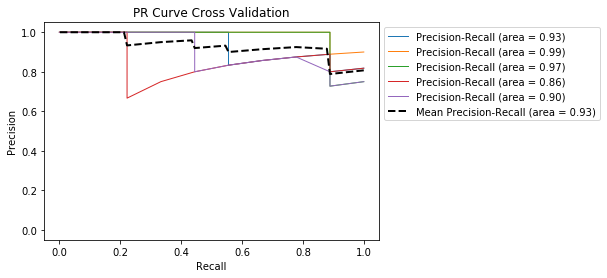

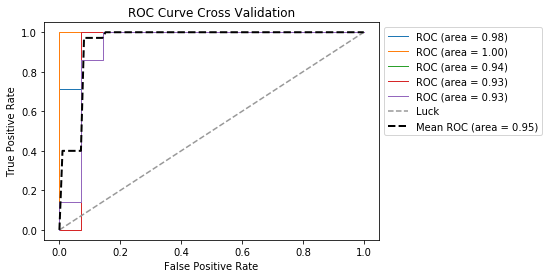

In [65]:
# plot CV for RF
fig_rf = cross_val_pr(1,x_train_comb,y_train_comb,'PR Curve Cross Validation')
fig_rf.savefig('ml_analysis/full_multiomic_figures/rf_base+meta_cv_pr.pdf',bbox_inches='tight')

fig_rf = cross_val_roc(1,x_train_comb,y_train_comb,'ROC Curve Cross Validation')
fig_rf.savefig('ml_analysis/full_multiomic_figures/rf_base+meta_cv_roc.pdf',bbox_inches='tight')

In [68]:
# training Log Reg on training data
comb_lr = LogisticRegression(random_state=0,max_iter=300)
comb_lr.fit(x_train_comb, y_train_comb)

LogisticRegression(max_iter=300, random_state=0)

In [69]:
# training RF on training data
comb_rf = RandomForestClassifier(500, oob_score=True, random_state=0)
comb_rf.fit(x_train_comb, y_train_comb)
comb_rf.oob_score_

0.9142857142857143

### 4b. Testing Models on G3R data

In [70]:
exp_test.adv_fibrosis.value_counts()

0    21
1     7
Name: adv_fibrosis, dtype: int64

In [71]:
x_test_comb = pd.concat([x_test_base, clin_feat.loc[exp_test.index]],axis=1)
x_test_comb.gender = pd.factorize(x_test_comb.gender)[0]
x_test_comb.shape

(28, 129)

In [72]:
# Preparing the test data
y_test_comb = []
for idx in x_test_comb.index:
    if meta.loc[idx,'ATTRIBUTE_adv_fibrosis'] == '1':
        y_test_comb.append(1)
    elif meta.loc[idx,'ATTRIBUTE_adv_fibrosis'] == '0':
        y_test_comb.append(0)
y_test_comb = np.array(y_test_comb)
print(len(y_test_comb))

28


In [73]:
# testing log reg
result_comb_lr = pd.DataFrame(comb_lr.predict_proba(x_test_comb))
result_comb_lr.columns = comb_lr.classes_
result_comb_lr['Y_TRUE'] = y_test_comb
result_comb_lr['CV'] = 0

Average precision-recall score: 0.35


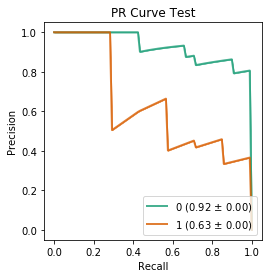

In [74]:
# showing Precision-recall results
fig_comb_lr = plot_result_pr(result_comb_lr,'PR Curve Test')
fig_comb_lr.savefig('ml_analysis/full_multiomic_figures/lr_base+meta_test_pr.pdf',bbox_inches='tight')

average_precision = metrics.average_precision_score(y_test_comb, comb_lr.predict(x_test_comb))

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

Accuracy score: 0.54


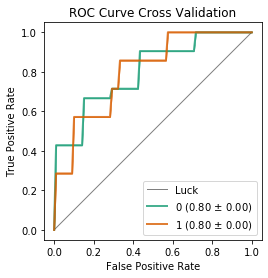

In [75]:
# showing accuracy/ROC results
fig_comb_lr = plot_result_roc(result_comb_lr,'ROC Curve Cross Validation')
fig_comb_lr.savefig('ml_analysis/full_multiomic_figures/lr_base+meta_test_roc.pdf',bbox_inches='tight')

acc_score = metrics.accuracy_score(y_test_comb, comb_lr.predict(x_test_comb))

print('Accuracy score: {0:0.2f}'.format(
      acc_score))

In [76]:
# testing RF
result_comb_rf = pd.DataFrame(comb_rf.predict_proba(x_test_comb))
result_comb_rf.columns = comb_rf.classes_
result_comb_rf['Y_TRUE'] = y_test_comb
result_comb_rf['CV'] = 0

Average precision-recall score: 0.25


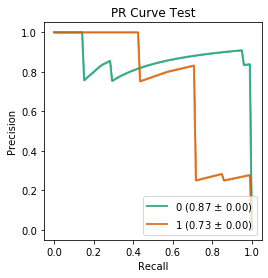

In [77]:
# showing Precision-recall results
fig_comb_rf = plot_result_pr(result_comb_rf,'PR Curve Test')
fig_comb_rf.savefig('ml_analysis/full_multiomic_figures/rf_base+meta_test_pr.pdf',bbox_inches='tight')

average_precision = metrics.average_precision_score(y_test_comb, comb_rf.predict(x_test_comb))

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

Accuracy score: 0.32


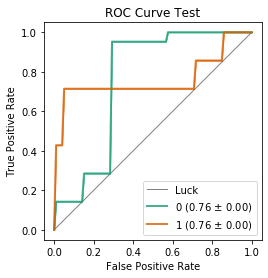

In [78]:
# showing accuracy/ROC results
fig_comb_rf = plot_result_roc(result_comb_rf,'ROC Curve Test')
fig_comb_rf.savefig('ml_analysis/full_multiomic_figures/rf_base+meta_test_roc.pdf',bbox_inches='tight')

acc_score = metrics.accuracy_score(y_test_comb, comb_rf.predict(x_test_comb))

print('Accuracy score: {0:0.2f}'.format(
      acc_score))

## 5. Adding BMI, Gender and Age to Selected Feature Table
The selected features from the full multi-omic model heavily favored serum features. We will again add the metadata features to the model and see how the combination of serum and metadata features performs.

### 5a. CV/Train Model on G1P+G3P Samples

In [79]:
x_train_combSel = pd.concat([x_train_feat1, clin_feat.loc[exp_train.index]],axis=1)
x_train_combSel.gender = pd.factorize(x_train_combSel.gender)[0]
print(x_train_combSel.shape)
x_train_combSel.head(3)

(70, 61)


,027b52f7e9c453c4db513e9a266b6915,01f9feb2a4c23ae6dbbfddd03a30a949,0599a329b2d7c76a78d954fc5e1b7a51,02c6164bb3acbb7a09c021689f272c1d,05499b638ac0dd75492cc1937ce93aa6,05b7691209e78a8527945f6b5b0bcfb4,04594b884377a2bd2550c5d4d956e08b,05163992b2900dfeb473198f34648669,0573a1a5857d294ca17802105e3cae29,0074f0d3d22016bcdf28ee53c8a5062b,...,04fae26c24c8c1aeb7379099ed4b1584,71b646c82731aa8e14f60ee428337721,AACGTAGGTCACAAGCGTTGTCCGGAATTACTGGGTGTAAAGGGAGCGCAGGCGGGAAGACAAGTTGGAAGTGAAATCCATGGGCTCAACCCATGAACTGCTTTCAAAACTGTTTTTCTTGAGTAGTGCAGAGGTAGGCGGAATTCCCGG,901b6e2bf2d45cfa9b38a99784cd0459,TACGTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAGCGTAGACGGTTAAGCAAGTCTGAAGTGAAAGCCCGGGGCTCAACCCCGGTACTGCTTTGGAAACTGTTTGACTTGAGTGCAGGAGAGGTAAGTGGAATTCCTAG,AACGTAGGTCACAAGCGTTGTCCGGAATTACTGGGTGTAAAGGGAGCGCAGGCGGGAAGACAAGTTGGAAGTGAAATCTATGGGCTCAACCCATAAACTGCTTTCAAAACTGTTTTTCTTGAGTAGTGCAGAGGTAGGCGGAATTCCCGG,05e8e382396ab145840c525c267d4d25,gender,bmi,age
sampleid,,,,,,,,,,,,,,,,,,,,,
TW-BS-002,-0.081804,0.716375,0.298108,-0.129371,-0.574743,-0.525662,0.172935,-0.571234,-0.669434,-0.052525,...,-0.159182,-0.193359,-0.082995,-0.254814,-0.139397,0.991486,-0.232727,0,28.8,22
TW-BU-002,-0.245010,-0.040684,-0.360257,-0.123324,-0.706262,-0.523605,0.384241,-0.575890,-0.667621,-0.064788,...,-0.202214,-0.193359,-0.464552,-0.254814,-0.082825,-0.595442,-0.241394,1,23.7,22
TW-BK-001,-0.197466,0.234400,-0.560658,-0.039743,-0.739330,-0.523888,1.002192,-0.569097,-0.671352,-0.130301,...,-0.672067,-0.193359,-0.060010,-0.254814,-0.139397,-0.333705,0.424438,1,26.6,60


In [80]:
y_train_combSel = []
for idx in x_train_combSel.index:
    if meta.loc[idx, 'ATTRIBUTE_adv_fibrosis'] == '1':
        y_train_combSel.append(1)
    else:    
        y_train_combSel.append(0)
y_train_combSel = np.array(y_train_combSel)
print(len(y_train_combSel))

70


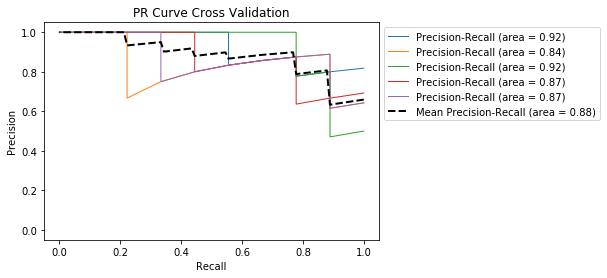

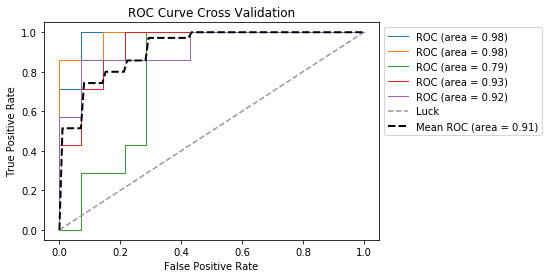

In [81]:
# plot CV for LogReg
fig_lr = cross_val_pr(0,x_train_combSel,y_train_combSel,'PR Curve Cross Validation')
fig_lr.savefig('ml_analysis/full_multiomic_figures/lr_selected+meta_cv_pr.pdf',bbox_inches='tight')

fig_lr = cross_val_roc(0,x_train_combSel,y_train_combSel,'ROC Curve Cross Validation')
fig_lr.savefig('ml_analysis/full_multiomic_figures/lr_selected+meta_cv_roc.pdf',bbox_inches='tight')


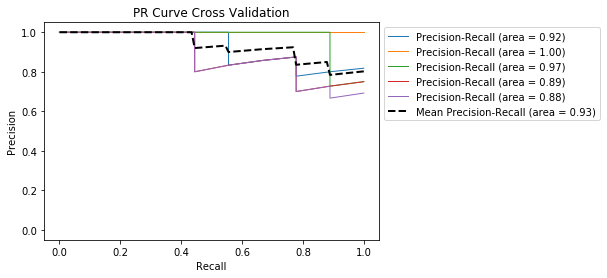

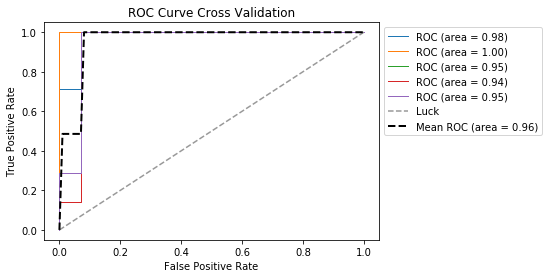

In [82]:
# plot CV for RF
fig_rf = cross_val_pr(1,x_train_combSel,y_train_combSel,'PR Curve Cross Validation')
fig_rf.savefig('ml_analysis/full_multiomic_figures/rf_selected+meta_cv_pr.pdf',bbox_inches='tight')

fig_rf = cross_val_roc(1,x_train_combSel,y_train_combSel,'ROC Curve Cross Validation')
fig_rf.savefig('ml_analysis/full_multiomic_figures/rf_selected+meta_cv_roc.pdf',bbox_inches='tight')

In [83]:
# training Log Reg on training data
combSel_lr = LogisticRegression(random_state=0,max_iter=300)
combSel_lr.fit(x_train_combSel, y_train_combSel)

LogisticRegression(max_iter=300, random_state=0)

In [84]:
# training RF on training data
combSel_rf = RandomForestClassifier(500, oob_score=True, random_state=0)
combSel_rf.fit(x_train_combSel, y_train_combSel)
combSel_rf.oob_score_

0.9285714285714286

### 5b. Testing Models on G3R data

In [85]:
exp_test.adv_fibrosis.value_counts()

0    21
1     7
Name: adv_fibrosis, dtype: int64

In [86]:
x_test_combSel = pd.concat([x_test_feat1, clin_feat.loc[exp_test.index]],axis=1)
x_test_combSel.gender = pd.factorize(x_test_combSel.gender)[0]
x_test_combSel.shape

(28, 61)

In [87]:
# Preparing the test data
y_test_combSel = []
for idx in x_test_combSel.index:
    if meta.loc[idx,'ATTRIBUTE_adv_fibrosis'] == '1':
        y_test_combSel.append(1)
    elif meta.loc[idx,'ATTRIBUTE_adv_fibrosis'] == '0':
        y_test_combSel.append(0)
y_test_combSel = np.array(y_test_combSel)
print(len(y_test_combSel))

28


In [88]:
# testing log reg
result_combSel_lr = pd.DataFrame(combSel_lr.predict_proba(x_test_combSel))
result_combSel_lr.columns = combSel_lr.classes_
result_combSel_lr['Y_TRUE'] = y_test_combSel
result_combSel_lr['CV'] = 0

Average precision-recall score: 0.29


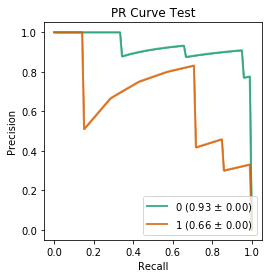

In [89]:
# showing Precision-recall results
fig_comb_lr = plot_result_pr(result_combSel_lr,'PR Curve Test')
fig_comb_lr.savefig('ml_analysis/full_multiomic_figures/lr_selected+meta_test_pr.pdf',bbox_inches='tight')

average_precision = metrics.average_precision_score(y_test_combSel, combSel_lr.predict(x_test_combSel))

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

Accuracy score: 0.46


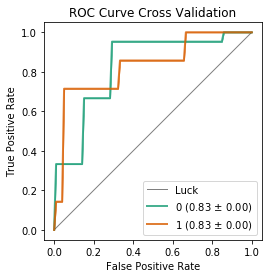

In [90]:
# showing accuracy/ROC results
fig_comb_lr = plot_result_roc(result_combSel_lr,'ROC Curve Cross Validation')
fig_comb_lr.savefig('ml_analysis/full_multiomic_figures/lr_selected+meta_test_roc.pdf',bbox_inches='tight')

acc_score = metrics.accuracy_score(y_test_combSel, combSel_lr.predict(x_test_combSel))

print('Accuracy score: {0:0.2f}'.format(
      acc_score))

In [91]:
# testing RF
result_combSel_rf = pd.DataFrame(combSel_rf.predict_proba(x_test_combSel))
result_combSel_rf.columns = combSel_rf.classes_
result_combSel_rf['Y_TRUE'] = y_test_combSel
result_combSel_rf['CV'] = 0

Average precision-recall score: 0.25


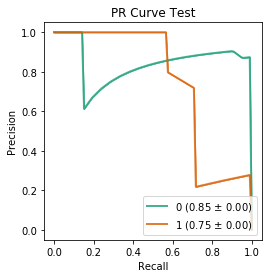

In [92]:
# showing Precision-recall results
fig_comb_rf = plot_result_pr(result_combSel_rf,'PR Curve Test')
fig_comb_rf.savefig('ml_analysis/full_multiomic_figures/rf_selected+meta_test_pr.pdf',bbox_inches='tight')

average_precision = metrics.average_precision_score(y_test_combSel, combSel_rf.predict(x_test_combSel))

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

Accuracy score: 0.32


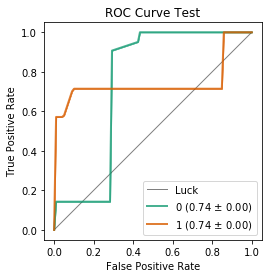

In [93]:
# showing accuracy/ROC results
fig_comb_rf = plot_result_roc(result_combSel_rf,'ROC Curve Test')
fig_comb_rf.savefig('ml_analysis/full_multiomic_figures/rf_selected+meta_test_roc.pdf',bbox_inches='tight')

acc_score = metrics.accuracy_score(y_test_combSel, combSel_rf.predict(x_test_combSel))

print('Accuracy score: {0:0.2f}'.format(
      acc_score))

This time around we don't see quite as large of a dropoff in performance when we have the serum features combined with the metadata features. Will have to split up the metabolomics and build multi-omic models off them to see how they can perform with the microbial features.